# Generate simulation data

In [383]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
#from operator import xor
#from blocks import Blocks
from worm_simulation import WormSimulation
from bonds import Bonds
from specific_heat import SpecificHeat
from pca import PrincipalComponent
#from iterated_blocking import *
#from count_bonds import *
from specific_heat import SpecificHeat
from count_bonds import *
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnchoredText
import matplotlib.offsetbox as offsetbox


%matplotlib notebook
import matplotlib as mpl
label_size = 14
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

Tc =  2./np.log(1+np.sqrt(2))

In [452]:
#for i in range(10):
print("\n" + 80*"*" + "\n")
print("Run #: {}".format(i))
print("\n" + 80*"*" + "\n")
bonds32 = Bonds(32, run=True, num_steps=1E8, T_start=1.8, T_end=2.8, T_step=0.05)
bonds16 = Bonds(16, run=True, num_steps=1E8, T_start=1.8, T_end=2.8, T_step=0.05)
bonds8 = Bonds(8, run=True, num_steps=1E8, T_start=1.8, T_end=2.8, T_step=0.05)
bonds4 = Bonds(4, run=True, num_steps=1E8, T_start=1.8, T_end=2.8, T_step=0.05)
bonds4 = Bonds(4, run=True, num_steps=1E8)
bonds8 = Bonds(8, run=True, num_steps=1E8)
bonds16 = Bonds(16, run=True, num_steps=1E8)
bonds32 = Bonds(32, run=True, num_steps=1E7)


********************************************************************************

Run #: 0

********************************************************************************

compilation -- start

compilation -- done

runs -- start

Running T = 1.8, num_steps: 100000000.0
Running T = 1.85, num_steps: 95263157.89473684
Running T = 1.9, num_steps: 90526315.78947368
Running T = 1.95, num_steps: 85789473.68421052
Running T = 2.0, num_steps: 81052631.57894737
Running T = 2.05, num_steps: 76315789.4736842
Running T = 2.1, num_steps: 71578947.36842105
Running T = 2.15, num_steps: 66842105.2631579
Running T = 2.2, num_steps: 62105263.15789474
Running T = 2.25, num_steps: 57368421.05263158
Running T = 2.3, num_steps: 52631578.94736842
Running T = 2.35, num_steps: 47894736.84210526
Running T = 2.4, num_steps: 43157894.73684211
Running T = 2.45, num_steps: 38421052.63157895
Running T = 2.5, num_steps: 33684210.52631579
Running T = 2.55, num_steps: 28947368.421052635
Running T = 2.6, num_steps: 24

Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.4.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_3.1.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.0.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.1.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.2.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.4.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.5.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_3.0.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bo

Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.8.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_3.3.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.6.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.7.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.5.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.4.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_3.1.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.0.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.1.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.3.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.2.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.4.txt
Saving configs to: ../data/configs/16_lattice/separa

Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.5.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.0.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.2.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.7.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.6.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.3.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.4.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.1.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.0.txt

*************************************************

Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.3.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.4.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.1.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.0.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.8.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.9.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.9.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.8.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_3.3.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.6.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.7.txt
Saving blocked configs to: ../data/blocke

Running T = 1.6, num_steps: 77500000.0
Running T = 1.7, num_steps: 73750000.0
Running T = 1.8, num_steps: 70000000.0
Running T = 1.9, num_steps: 66250000.0
Running T = 2.0, num_steps: 62500000.0
Running T = 2.1, num_steps: 58750000.0
Running T = 2.2, num_steps: 55000000.0
Running T = 2.3, num_steps: 51250000.0
Running T = 2.4, num_steps: 47500000.0
Running T = 2.5, num_steps: 43750000.0
Running T = 2.6, num_steps: 40000000.0
Running T = 2.7, num_steps: 36250000.0
Running T = 2.8, num_steps: 32500000.0
Running T = 2.9, num_steps: 28750000.0
Running T = 3.0, num_steps: 25000000.0
Running T = 3.1, num_steps: 21250000.0
Running T = 3.2, num_steps: 17500000.0
Running T = 3.3, num_steps: 13750000.0
Running T = 3.4, num_steps: 10000000.0
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.8.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.9.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.9.txt
Saving configs to: ../

Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.8.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.3.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.6.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.7.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.4.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.1.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.0.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.1.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs

Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.7.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.5.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.4.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.1.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.0.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.1.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.3.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.2.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.4.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.5.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.0.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.2.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.7.txt

Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.0.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.2.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.7.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.6.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.3.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.4.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.1.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.0.txt
compilation -- start

compilation -- done

runs -- start

Running T = 1.0, num_steps: 100000000.0
Running T = 1.1, num_steps: 96250000.0
Running T = 1.2, num_steps

Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.2.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.4.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.5.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.0.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.2.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.7.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.6.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.2.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.3.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.4.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.1.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.0.txt
Saving blocked configs to: ../data/blocked_configs/3

Running T = 1.5, num_steps: 81250000.0
Running T = 1.6, num_steps: 77500000.0
Running T = 1.7, num_steps: 73750000.0
Running T = 1.8, num_steps: 70000000.0
Running T = 1.9, num_steps: 66250000.0
Running T = 2.0, num_steps: 62500000.0
Running T = 2.1, num_steps: 58750000.0
Running T = 2.2, num_steps: 55000000.0
Running T = 2.3, num_steps: 51250000.0
Running T = 2.4, num_steps: 47500000.0
Running T = 2.5, num_steps: 43750000.0
Running T = 2.6, num_steps: 40000000.0
Running T = 2.7, num_steps: 36250000.0
Running T = 2.8, num_steps: 32500000.0
Running T = 2.9, num_steps: 28750000.0
Running T = 3.0, num_steps: 25000000.0
Running T = 3.1, num_steps: 21250000.0
Running T = 3.2, num_steps: 17500000.0
Running T = 3.3, num_steps: 13750000.0
Running T = 3.4, num_steps: 10000000.0
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.8.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.9.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_conf

Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.8.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.3.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.6.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.7.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.4.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.1.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.0.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.1.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bo

Running T = 2.9, num_steps: 2875000.0
Running T = 3.0, num_steps: 2500000.0
Running T = 3.1, num_steps: 2125000.0
Running T = 3.2, num_steps: 1750000.0
Running T = 3.3, num_steps: 1375000.0
Running T = 3.4, num_steps: 1000000.0
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.8.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.9.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.9.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.8.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.3.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.6.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.7.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.5.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.4.txt
Saving configs to: ../data/configs/32_lattice/separated_data/

Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.7.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.95.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.1.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.4.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.85.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.6.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.0.txt
compilation -- start

compilation -- done

runs 

Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.3.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.2.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.4.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.5.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_3.0.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_3.2.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.7.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.6.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.2.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.3.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_3.4.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.1.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.0.txt

Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.3.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_3.4.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.1.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.0.txt
compilation -- start

compilation -- done

runs -- start

Running T = 1.0, num_steps: 10000000.0
Running T = 1.1, num_steps: 9625000.0
Running T = 1.2, num_steps: 9250000.0
Running T = 1.3, num_steps: 8875000.0
Running T = 1.4, num_steps: 8500000.0
Running T = 1.5, num_steps: 8125000.0
Running T = 1.6, num_steps: 7750000.0
Running T = 1.7, num_steps: 7375000.0
Running T = 1.8, num_steps: 7000000.0
Running T = 1.9, num_steps: 6625000.0
Running T = 2.0, num_steps: 6250000.0
Running T = 2.1, num_steps: 5875000.0
Running T 

Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.85.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.6.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.2.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.0.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.15.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.35.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.75.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.55.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.9.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.25.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.05.txt
Saving block

Running T = 2.6, num_steps: 40000000.0
Running T = 2.7, num_steps: 36250000.0
Running T = 2.8, num_steps: 32500000.0
Running T = 2.9, num_steps: 28750000.0
Running T = 3.0, num_steps: 25000000.0
Running T = 3.1, num_steps: 21250000.0
Running T = 3.2, num_steps: 17500000.0
Running T = 3.3, num_steps: 13750000.0
Running T = 3.4, num_steps: 10000000.0
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.8.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.9.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.9.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.8.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_3.3.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.6.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.7.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.5.txt
Saving configs to: ../data/config

Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.4.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_3.1.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.0.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.1.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.2.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.4.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.5.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_3.0.txt
Saving blocked configs to: ../data/blocked_configs

Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.15.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.35.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.75.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.55.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.9.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.25.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.05.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.45.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.8.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.65.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.7.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.5.txt
Saving configs to: ../data/configs/32_lattic

Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.6.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.3.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_3.4.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.1.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.0.txt
compilation -- start

compilation -- done

runs -- start

Running T = 1.0, num_steps: 100000000.0
Running T = 1.1, num_steps: 96250000.0
Running T = 1.2, num_steps: 92500000.0
Running T = 1.3, num_steps: 88750000.0
Running T = 1.4, num_steps: 85000000.0
Running T = 1.5, num_steps: 81250000.0
Running T = 1.6, num_steps: 77500000.0
Running T = 1.7, num_steps: 73750000.0
Running T = 1.8, num_steps: 70000000.0
Running T = 1.9, num_steps: 6625

Saving configs to: ../data/configs/16_lattice/separated_data/16_config_3.2.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.7.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.6.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.2.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.3.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_3.4.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.1.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.0.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.8.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.9.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.9.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_con


********************************************************************************

Run #: 7

********************************************************************************

compilation -- start

compilation -- done

runs -- start

Running T = 1.8, num_steps: 100000000.0
Running T = 1.85, num_steps: 95263157.89473684
Running T = 1.9, num_steps: 90526315.78947368
Running T = 1.95, num_steps: 85789473.68421052
Running T = 2.0, num_steps: 81052631.57894737
Running T = 2.05, num_steps: 76315789.4736842
Running T = 2.1, num_steps: 71578947.36842105
Running T = 2.15, num_steps: 66842105.2631579
Running T = 2.2, num_steps: 62105263.15789474
Running T = 2.25, num_steps: 57368421.05263158
Running T = 2.3, num_steps: 52631578.94736842
Running T = 2.35, num_steps: 47894736.84210526
Running T = 2.4, num_steps: 43157894.73684211
Running T = 2.45, num_steps: 38421052.63157895
Running T = 2.5, num_steps: 33684210.52631579
Running T = 2.55, num_steps: 28947368.421052635
Running T = 2.6, num_steps: 24

Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.4.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_3.1.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.0.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.1.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.2.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.4.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.5.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_3.0.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bo

Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.8.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_3.3.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.6.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.7.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.5.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.4.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_3.1.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.0.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.1.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.3.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.2.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.4.txt
Saving configs to: ../data/configs/16_lattice/separa

Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.5.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.0.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.2.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.7.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.6.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.3.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.4.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.1.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.0.txt

*************************************************

Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.3.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.4.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.1.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.0.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.8.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.9.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.9.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.8.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_3.3.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.6.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.7.txt
Saving blocked configs to: ../data/blocke

Running T = 1.6, num_steps: 77500000.0
Running T = 1.7, num_steps: 73750000.0
Running T = 1.8, num_steps: 70000000.0
Running T = 1.9, num_steps: 66250000.0
Running T = 2.0, num_steps: 62500000.0
Running T = 2.1, num_steps: 58750000.0
Running T = 2.2, num_steps: 55000000.0
Running T = 2.3, num_steps: 51250000.0
Running T = 2.4, num_steps: 47500000.0
Running T = 2.5, num_steps: 43750000.0
Running T = 2.6, num_steps: 40000000.0
Running T = 2.7, num_steps: 36250000.0
Running T = 2.8, num_steps: 32500000.0
Running T = 2.9, num_steps: 28750000.0
Running T = 3.0, num_steps: 25000000.0
Running T = 3.1, num_steps: 21250000.0
Running T = 3.2, num_steps: 17500000.0
Running T = 3.3, num_steps: 13750000.0
Running T = 3.4, num_steps: 10000000.0
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.8.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.9.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.9.txt
Saving configs to: ../

Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.8.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.3.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.6.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.7.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.4.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.1.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.0.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.1.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs

Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.7.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.5.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.4.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.1.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.0.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.1.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.3.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.2.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.4.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.5.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.0.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.2.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.7.txt

Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.0.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.2.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.7.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.6.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.3.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.4.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.1.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.0.txt
compilation -- start

compilation -- done

runs -- start

Running T = 1.0, num_steps: 100000000.0
Running T = 1.1, num_steps: 96250000.0
Running T = 1.2, num_steps

Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.2.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.4.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.5.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.0.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.2.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.7.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.6.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.2.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.3.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.4.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.1.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.0.txt
Saving blocked configs to: ../data/blocked_configs/3

In [ ]:
Bonds(32, run=True, num_steps=1E8, decay_steps=False, T_start=1.8, T_end=2.8, T_step=0.05)
Bonds(16, run=True, num_steps=1E8, decay_steps=False, T_start=1.8, T_end=2.8, T_step=0.05)
Bonds(8, run=True, num_steps=1E8, decay_steps=False, T_start=1.8, T_end=2.8, T_step=0.05)
Bonds(4, run=True, num_steps=1E8, decay_steps=False, T_start=1.8, T_end=2.8, T_step=0.05)
Bonds(32, run=True, num_steps=1E8, decay_steps=False, T_start=1., T_end=4., T_step=0.1)
Bonds(16, run=True, num_steps=1E8, decay_steps=False, T_start=1., T_end=4., T_step=0.1)
Bonds(8, run=True, num_steps=1E8, decay_steps=False, T_start=1., T_end=4., T_step=0.1)
Bonds(4, run=True, num_steps=1E8, decay_steps=False, T_start=1., T_end=4., T_step=0.1)

compilation -- start

compilation -- done

runs -- start

Running T = 1.8, num_steps: 100000000.0
Running T = 1.85, num_steps: 100000000.0
Running T = 1.9, num_steps: 100000000.0
Running T = 1.95, num_steps: 100000000.0
Running T = 2.0, num_steps: 100000000.0
Running T = 2.05, num_steps: 100000000.0
Running T = 2.1, num_steps: 100000000.0
Running T = 2.15, num_steps: 100000000.0
Running T = 2.2, num_steps: 100000000.0
Running T = 2.25, num_steps: 100000000.0
Running T = 2.3, num_steps: 100000000.0
Running T = 2.35, num_steps: 100000000.0
Running T = 2.4, num_steps: 100000000.0
Running T = 2.45, num_steps: 100000000.0
Running T = 2.5, num_steps: 100000000.0
Running T = 2.55, num_steps: 100000000.0
Running T = 2.6, num_steps: 100000000.0
Running T = 2.65, num_steps: 100000000.0
Running T = 2.7, num_steps: 100000000.0
Running T = 2.75, num_steps: 100000000.0
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.15.txt
Saving configs to: ../data/configs/32_lattice/separa

Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.4.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.85.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.6.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.0.txt
compilation -- start

compilation -- done

runs -- start

Running T = 1.8, num_steps: 100000000.0
Running T = 1.85, num_steps: 100000000.0
Running T = 1.9, num_steps: 100000000.0
Running T = 1.95, num_steps: 100000000.0
Running T = 2.0, num_steps: 100000000.0
Running T = 2.05, num_steps: 100000000.0
Running T = 2.1, num_steps: 100000000.0
Running T = 2.15, num_steps: 100000000.0
Running T = 2.2, num_steps: 100000000.0
Running T = 2.25, num_steps: 100000000.0
Running T = 2.3, num_steps: 100000000.0
Running T = 2.35, num

Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.95.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.1.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.4.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.85.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.6.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.0.txt
compilation -- start

compilation -- done

runs -- start

Running T = 1.0, num_steps: 100000000.0
Running T = 1.1, num_steps: 100000000.0
Running T = 1.2, num_st

In [317]:
bonds32 = Bonds(32, run=True, num_steps=1E8)

compilation -- start

compilation -- done

runs -- start

Running T = 1.0
Running T = 1.1
Running T = 1.2
Running T = 1.3
Running T = 1.4
Running T = 1.5
Running T = 1.6
Running T = 1.7
Running T = 1.8
Running T = 1.9
Running T = 2.0
Running T = 2.1
Running T = 2.2
Running T = 2.3
Running T = 2.4
Running T = 2.5
Running T = 2.6
Running T = 2.7
Running T = 2.8
Running T = 2.9
Running T = 3.0
Running T = 3.1
Running T = 3.2
Running T = 3.3
Running T = 3.4
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.8.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.9.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.9.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.8.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.3.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.6.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_conf

## $\langle N_b \rangle$, and $\langle \Delta_{N_b}^2\rangle$

In [509]:
bc32 = bond_counter(32, write=True)
bc32_b = bond_counter(32, blocked_val=0, write=True)

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.0.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.1.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.2.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.3.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.4.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.5.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.6.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.7.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.8.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.85.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.9.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.95.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_2.0.txt

Reading from: ../data/c

In [510]:
bc16 = bond_counter(16, write=True)
bc16_b = bond_counter(16, blocked_val=0, write=True)

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.0.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.1.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.2.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.3.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.4.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.5.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.6.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.7.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.8.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.85.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.9.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.95.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_2.0.txt

Reading from: ../data/c

In [511]:
bc8 = bond_counter(8, write=True)
bc8_b = bond_counter(8, blocked_val=0, write=True)

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.0.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.1.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.2.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.3.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.4.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.5.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.6.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.7.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.8.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.85.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.9.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.95.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_2.0.txt

Reading from: ../data/configs/8_lattice/separated

In [512]:
bc4 = bond_counter(4, write=True)
bc4_b = bond_counter(4, blocked_val=0, write=True)

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.0.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.1.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.2.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.3.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.4.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.5.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.6.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.7.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.8.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.85.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.9.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.95.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_2.0.txt

Reading from: ../data/configs/4_lattice/separated

In [513]:
temps32 = np.array([float(i) for i in list(bc32.keys())])
flucts32 = np.array([i[3] for i in list(bc32.values())])
temps16 = np.array([float(i) for i in list(bc16.keys())])
flucts16 = np.array([i[3] for i in list(bc16.values())])
temps8 = np.array([float(i) for i in list(bc8.keys())])
flucts8 = np.array([i[3] for i in list(bc8.values())])
temps4 = np.array([float(i) for i in list(bc4.keys())])
flucts4 = np.array([i[3] for i in list(bc4.values())])

In [514]:
temps32_b = np.array([float(i) for i in list(bc32_b.keys())])
flucts32_b = np.array([i[3] for i in list(bc32_b.values())])
temps16_b = np.array([float(i) for i in list(bc16_b.keys())])
flucts16_b = np.array([i[3] for i in list(bc16_b.values())])
temps8_b = np.array([float(i) for i in list(bc8_b.keys())])
flucts8_b = np.array([i[3] for i in list(bc8_b.values())])
temps4_b = np.array([float(i) for i in list(bc4_b.keys())])
flucts4_b = np.array([i[3] for i in list(bc4_b.values())])

<IPython.core.display.Javascript object>


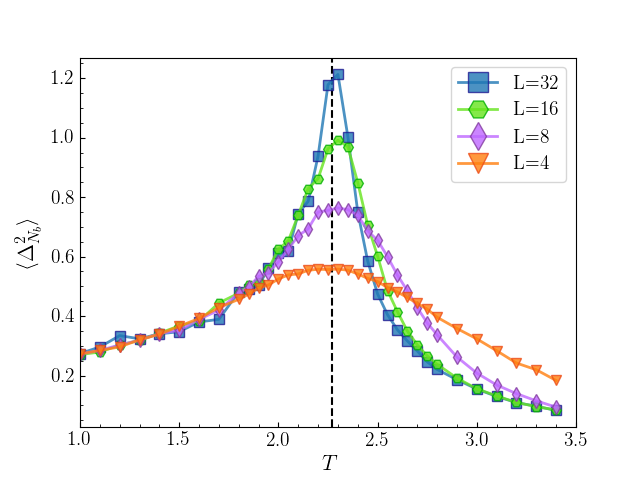

In [515]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.plot(temps32, flucts32/(2*32*32),
        marker='s', color='C0',
        markersize=7,  markeredgecolor='#1f1b93',
        ls='-', fillstyle='full', lw=2,
        alpha=0.8,
        label='L=32')
            
ax.plot(temps16, flucts16/(2*16*16),
        marker='H', color='#65e41d',
        markeredgecolor='#00B000', markersize=7., 
        lw=2, alpha=0.8, ls='-',
        fillstyle='full',
        label='L=16')

ax.plot(temps8, flucts8/(2*8*8),
        marker='d', fillstyle='full', color='#be67ff',
        markeredgecolor='#833c9f', markersize=7, 
        lw=2, alpha=0.8, ls='-',
        label='L=8')


ax.plot(temps4, flucts4/(2*4*4),
        color='C1', markeredgecolor='#ed4c18', marker='v', 
        fillstyle='full', markersize=7,  lw=2, 
        alpha=0.8, ls='-',
        label='L=4')


ax.legend(loc='best', markerscale=2, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle$", fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


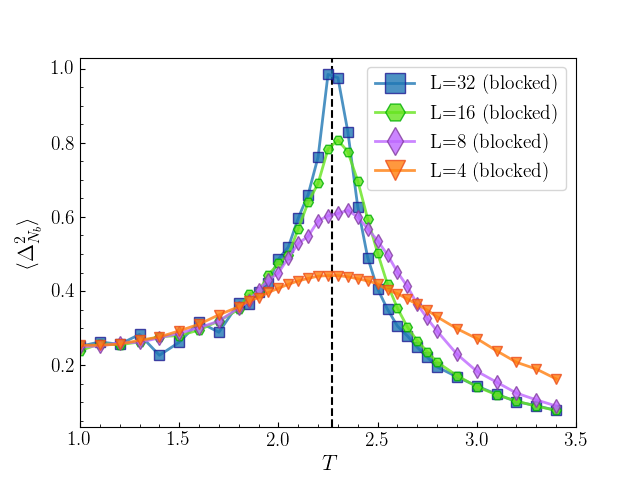

In [516]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.plot(temps32_b, flucts32_b/(2*16*16),
        marker='s', color='C0',
        markersize=7,  markeredgecolor='#1f1b93',
        ls='-', fillstyle='full', lw=2,
        alpha=0.8,
        label='L=32 (blocked)')
            
ax.plot(temps16_b, flucts16_b/(2*8*8),
        marker='H', color='#65e41d',
        markeredgecolor='#00B000', markersize=7., 
        lw=2, alpha=0.8, ls='-',
        fillstyle='full',
        label='L=16 (blocked)')

ax.plot(temps8_b, flucts8_b/(2*4*4),
        marker='d', fillstyle='full', color='#be67ff',
        markeredgecolor='#833c9f', markersize=7, 
        lw=2, alpha=0.8, ls='-',
        label='L=8 (blocked)')


ax.plot(temps4_b, flucts4_b/(2*2*2),
        color='C1', markeredgecolor='#ed4c18', marker='v', 
        fillstyle='full', markersize=7,  lw=2, 
        alpha=0.8, ls='-',
        label='L=4 (blocked)')


ax.legend(loc='best', markerscale=2, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle$", fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


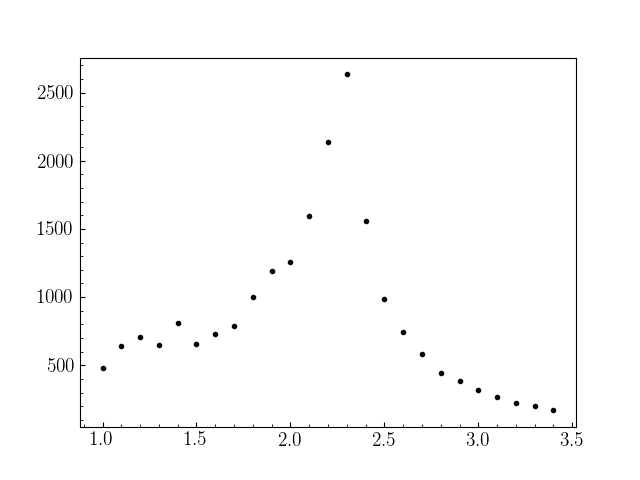

In [395]:
fig, ax = plt.subplots()
ax.plot(temps32, flucts32)
plt.show()

<IPython.core.display.Javascript object>


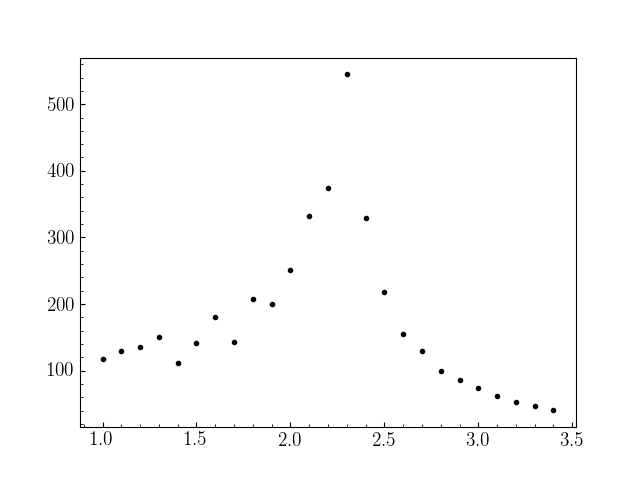

In [396]:
temps32_b = [float(i) for i in list(bc32_b.keys())]
flucts32_b = [i[3] for i in list(bc32_b.values())]
fig, ax = plt.subplots()
ax.plot(temps32_b, flucts32_b, 'k.')
plt.show()

## Principal Component Analysis

In [517]:
pca32 = PrincipalComponent(32)
pca32_b = PrincipalComponent(32, blocked_val=0)

Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.0.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.1.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.2.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.3.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.4.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.5.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.6.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.7.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.8.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.85.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.9.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.95.txt
Reading data from: ../data/configs/32_lattice/sepa

In [518]:
pca16 = PrincipalComponent(16)
pca16_b = PrincipalComponent(16, blocked_val=0)

Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.0.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.1.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.2.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.3.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.4.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.5.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.6.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.7.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.8.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.85.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.9.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.95.txt
Reading data from: ../data/configs/16_lattice/sepa

In [519]:
pca8 = PrincipalComponent(8)
pca8_b = PrincipalComponent(8, blocked_val=0)

Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.0.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.1.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.2.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.3.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.4.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.5.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.6.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.7.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.8.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.85.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.9.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.95.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_2.0.t

In [520]:
pca4 = PrincipalComponent(4)
pca4_b = PrincipalComponent(4, blocked_val=0)

Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.0.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.1.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.2.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.3.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.4.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.5.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.6.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.7.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.8.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.85.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.9.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.95.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.0.t

<IPython.core.display.Javascript object>


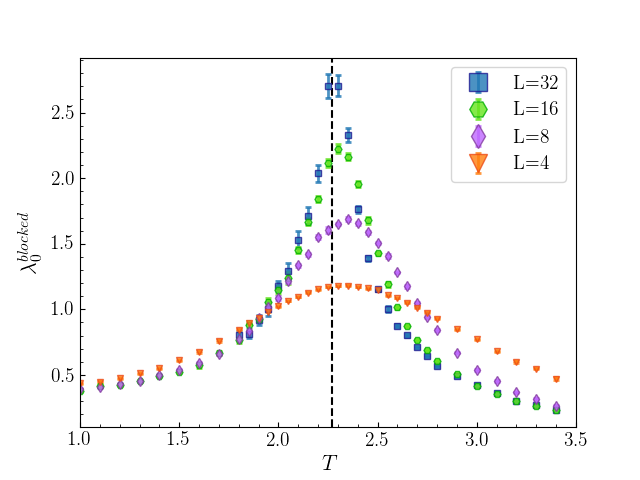

In [521]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')

ax.errorbar(pca32_b._temps, pca32_b._leading_eig_val_avg,
            yerr=list(pca32_b._err.values()),
            marker='s', color='C0',
            markersize=5,  markeredgecolor='#1f1b93',
            ls='', fillstyle='full', lw=1.,
            elinewidth=2.,  alpha=0.8,
            capsize=2, capthick=2,
            label='L=32')
            
ax.errorbar(pca16_b._temps, pca16_b._leading_eig_val_avg,
            yerr=list(pca16_b._err.values()),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=1., elinewidth=2.,  alpha=0.8, ls='',
            fillstyle='full', capsize=2, capthick=2, 
            label='L=16')

ax.errorbar(pca8_b._temps, pca8_b._leading_eig_val_avg,
            yerr=list(pca8_b._err.values()),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=1., elinewidth=2.,  alpha=0.8, ls='',
            capsize=2, capthick=2, 
            label='L=8')


ax.errorbar(pca4_b._temps, pca4_b._leading_eig_val_avg,
            yerr=list(pca4_b._err.values()),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=1.5, elinewidth=2., 
            alpha=0.8, capsize=2, capthick=2,  ls='',
            label='L=4')

ax.legend(loc='best', markerscale=2.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$\lambda_0^{blocked}$', fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


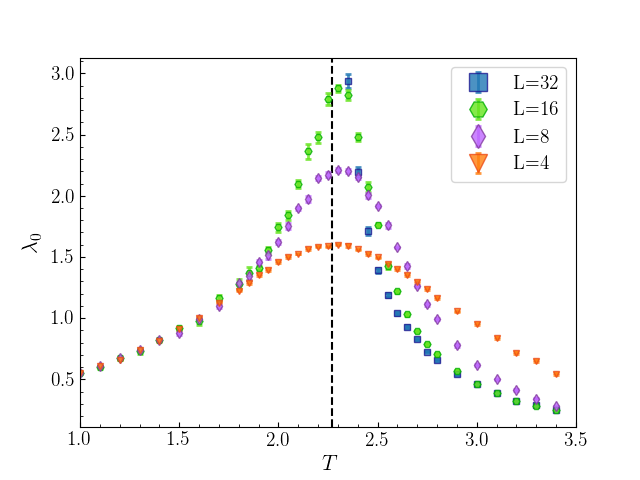

In [522]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')

ax.errorbar(pca32._temps, pca32._leading_eig_val_avg,
            yerr=list(pca32._err.values()),
            marker='s', color='C0',
            markersize=5,  markeredgecolor='#1f1b93',
            ls='', fillstyle='full', lw=1.,
            elinewidth=2.,  alpha=0.8,
            capsize=2, capthick=2,
            label='L=32')
            
ax.errorbar(pca16._temps, pca16._leading_eig_val_avg,
            yerr=list(pca16._err.values()),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=1., elinewidth=2.,  alpha=0.8, ls='',
            fillstyle='full', capsize=2, capthick=2, 
            label='L=16')

ax.errorbar(pca8._temps, pca8._leading_eig_val_avg,
            yerr=list(pca8._err.values()),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=1., elinewidth=2.,  alpha=0.8, ls='',
            capsize=2, capthick=2, 
            label='L=8')


ax.errorbar(pca4._temps, pca4._leading_eig_val_avg,
            yerr=list(pca4._err.values()),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=1.5, elinewidth=2., 
            alpha=0.8, capsize=2, capthick=2,  ls='',
            label='L=4')

ax.legend(loc='best', markerscale=2.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$\lambda_0$', fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

## Specific Heat

In [523]:
specific_heat32 = SpecificHeat(32)
specific_heat16 = SpecificHeat(16)
specific_heat8 = SpecificHeat(8)
specific_heat4 = SpecificHeat(4)

<IPython.core.display.Javascript object>


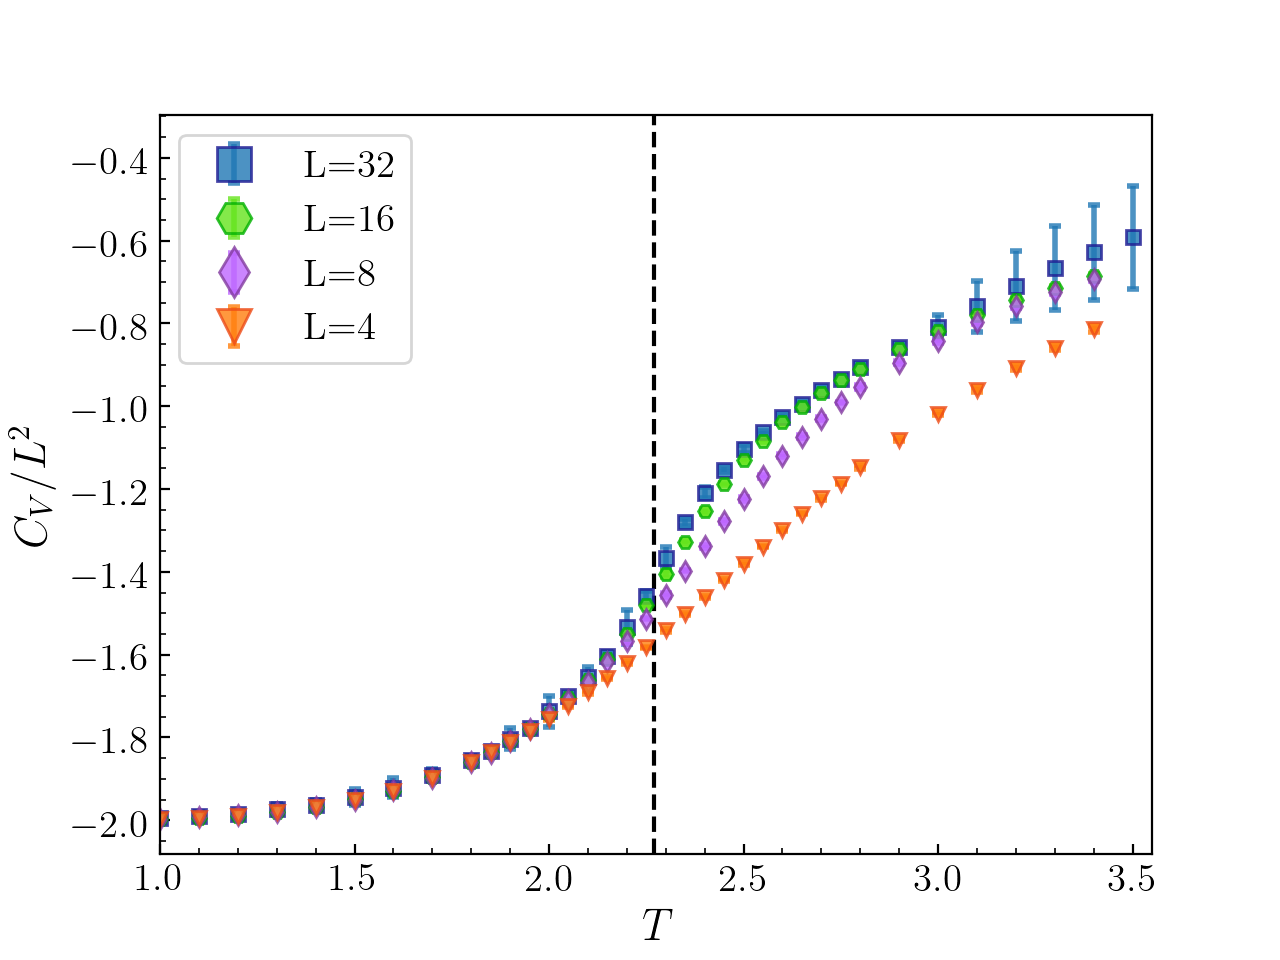

In [524]:
fig, ax = plt.subplots()
ax.errorbar(specific_heat32._energy_temps, specific_heat32._avg_energy,
            yerr=specific_heat32._energy_error,
            marker='s', color='C0',
            markersize=5,  markeredgecolor='#1f1b93',
            ls='', fillstyle='full', lw=1.,
            elinewidth=2.,  alpha=0.8,
            capsize=2, capthick=2,
            label='L=32')
            
ax.errorbar(specific_heat16._energy_temps, specific_heat16._avg_energy,
            yerr=specific_heat16._energy_error,
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=1., elinewidth=2.,  alpha=0.8, ls='',
            fillstyle='full', capsize=2, capthick=2, 
            label='L=16')

#ax.plot(t8, spec_heat8._Cv_arr, marker='.', ls='', markersize=5, mew=0.4, color='C0')
ax.errorbar(specific_heat8._energy_temps, specific_heat8._avg_energy,
            yerr=specific_heat8._energy_error,
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=1., elinewidth=2.,  alpha=0.8, ls='',
            capsize=2, capthick=2, 
            label='L=8')


ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
#ax.plot(t4, spec_heat4._Cv_arr, marker='.', ls='', markersize=5, mew=0.4, color='C0')
ax.errorbar(specific_heat4._energy_temps, specific_heat4._avg_energy,
            yerr=specific_heat4._energy_error,
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=1.5, elinewidth=2., 
            alpha=0.8, capsize=2, capthick=2,  ls='',
            label='L=4')

ax.legend(loc='best', markerscale=2.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.55)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$C_V/L^2$', fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

plt.show()

<IPython.core.display.Javascript object>


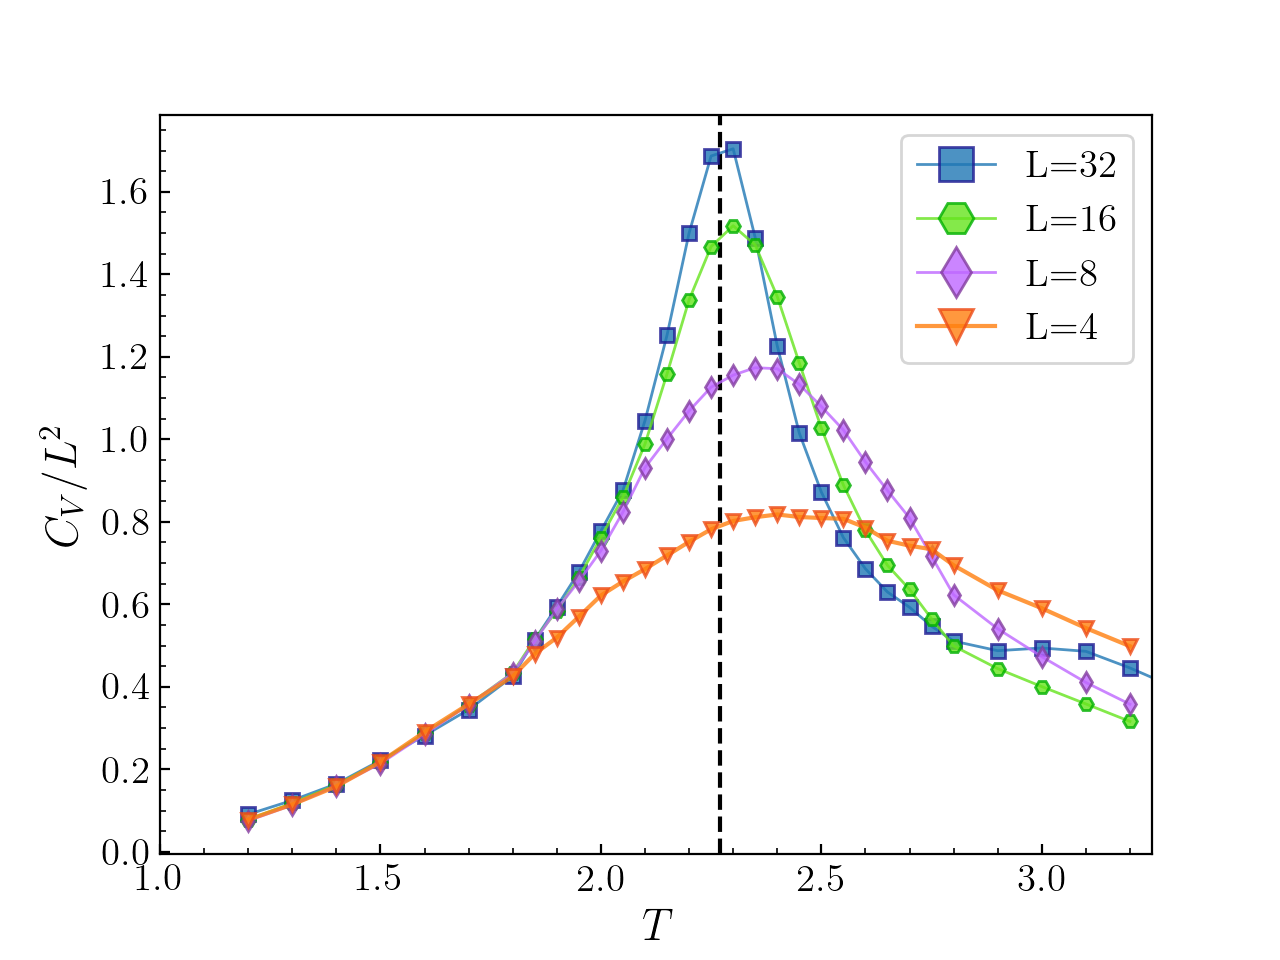

In [525]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.plot(specific_heat32._specific_heat_temps, specific_heat32._specific_heat,
            marker='s', color='C0',
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=1.,
            alpha=0.8,
            label='L=32')
            
ax.plot(specific_heat16._specific_heat_temps, specific_heat16._specific_heat,
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=1., alpha=0.8, ls='-',
            fillstyle='full',
            label='L=16')

ax.plot(specific_heat8._specific_heat_temps, specific_heat8._specific_heat,
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=1., alpha=0.8, ls='-',
            label='L=8')


ax.plot(specific_heat4._specific_heat_temps, specific_heat4._specific_heat,
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=1.5, 
            alpha=0.8, ls='-',
            label='L=4')


ax.legend(loc='best', markerscale=2.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.25)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$C_V/L^2$', fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

plt.show()